In [1]:
# import libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.path as mpath
from matplotlib.patches import Circle
import matplotlib.gridspec as gridspec
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset


from utils import Snapshot
from utils import read_snapshot
from utils import show_snap
from utils import diffraction_pattern
from utils import remove_center_pick
from utils import process_snap

# Load data set

In [2]:
# load dataset

# load fluid
path = './trainingset/fluid_train.npy'
fluid_train_data = list(np.load(path))
path = './trainingset/fluid_val.npy'
fluid_val_data = list(np.load(path))
nfluid_train = len(fluid_train_data)
nfluid_val = len(fluid_val_data)

# load square
path = './trainingset/square_train_rot.npy'
square_train_data = list(np.load(path))
path = './trainingset/square_val_rot.npy'
square_val_data = list(np.load(path))
nsquare_train = len(square_train_data)
nsquare_val = len(square_val_data)

# load hexagonal
path = './trainingset/hex_train_rot.npy'
hex_train_data = list(np.load(path))
path = './trainingset/hex_val_rot.npy'
hex_val_data = list(np.load(path))
nhex_train = len(hex_train_data)
nhex_val = len(hex_val_data)

# load qc12
path = './trainingset/qc12_train_rot.npy'
qc12_train_data = list(np.load(path))
path = './trainingset/qc12_val_rot.npy'
qc12_val_data = list(np.load(path))
nqc12_train = len(qc12_train_data)
nqc12_val = len(qc12_val_data)

# load qc10
path = './trainingset/qc10_train_rot.npy'
qc10_train_data = list(np.load(path))
path = './trainingset/qc10_val_rot.npy'
qc10_val_data = list(np.load(path))
nqc10_train = len(qc10_train_data)
nqc10_val = len(qc10_val_data)

# load qc18
path = './trainingset/qc18_train_rot.npy'
qc18_train_data = list(np.load(path))
path = './trainingset/qc18_val_rot.npy'
qc18_val_data = list(np.load(path))
nqc18_train = len(qc18_train_data)
nqc18_val = len(qc18_val_data)

# merge dataset
train_data = np.array(fluid_train_data + square_train_data + hex_train_data + qc12_train_data + qc10_train_data + qc18_train_data)
train_labels = np.array([0]*nfluid_train + [1]*nsquare_train + [2]*nhex_train + [3]*nqc12_train + [4]*nqc10_train + [5]*nqc18_train)

val_data = np.array(fluid_val_data + square_val_data + hex_val_data + qc12_val_data + qc10_val_data + qc18_val_data)
val_labels = np.array([0]*nfluid_val+ [1]*nsquare_val + [2]*nhex_val + [3]*nqc12_val + [4]*nqc10_val + [5]*nqc18_val)

classes = ['fluid', 'square', 'hexagonal', 'qc12' , 'qc10', 'qc18']
ntrain = len(train_data)
nval = len(val_data)
nclasses = len(classes)
print('Dimension of train dataset:  ' + str(ntrain))
print('Dimension of test  dataset:  ' + str(nval))
print('Input shape:                 ' + str(train_data[0].shape))
print('Number of classes:           ' + str(nclasses))

Dimension of train dataset:  48000
Dimension of test  dataset:  12000
Input shape:                 (1, 33, 33)
Number of classes:           6


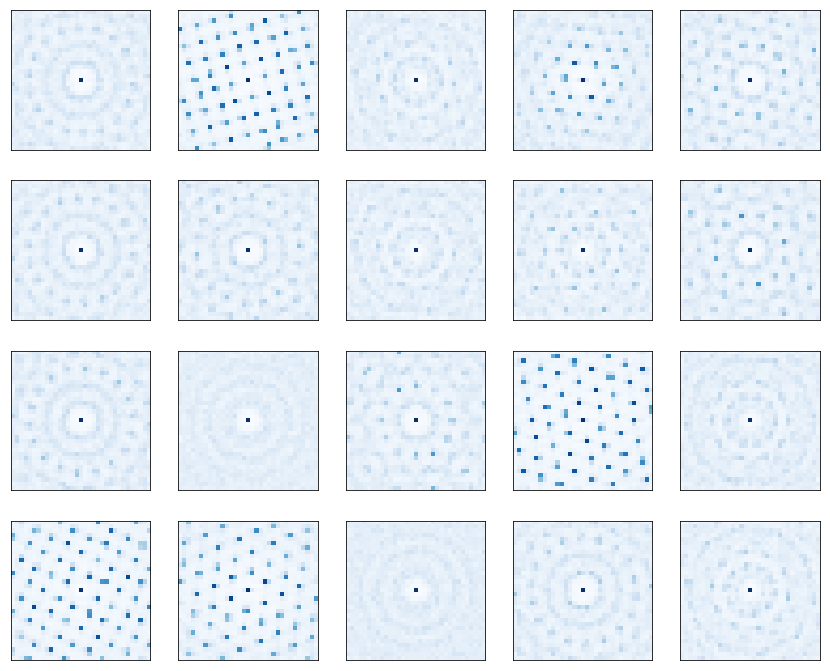

In [3]:
# show some training examples
size=(4,5)
idx = np.random.randint(0, ntrain, size=size)
fig, axs = plt.subplots(size[0], size[1], figsize=(size[1]*2.9, size[0]*3))
for i in range(size[0]):
    for j in range(size[1]):
        axs[i][j].imshow(train_data[idx[i][j]].squeeze(), cmap='Blues', interpolation='none')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
# plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Define neural network

In [4]:
device = torch.device('cpu')

# Xavier initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


# define neural networks
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 9, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(9, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(8 * 8 * 4, 20)
        self.fc2 = nn.Linear(20, 6)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# convert numpy to PyTorch variable for training
def get_var_from_np(np_array, cuda=False, requires_grad=False):    
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp

def get_label_from_np(np_array, cuda=False, requires_grad=False):    
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.LongTensor)
    if cuda: temp = temp.cuda()
    return temp

# construct dataset object for mini-batch gradient descent
class My_dataset(Dataset):      
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]
    
def augment_image(image, r=0):
    new_image = np.copy(image)
    if r==0:
        return new_image
    elif r==1:
        return new_image[:,::-1]
    elif r==2:
        return new_image[::-1,:]
    elif r==3:
        new_image = new_image[:,::-1]
        return new_image[::-1,:]
    elif r==4:
        return new_image.T
    elif r==5:
        new_image = new_image.T
        return new_image[:,::-1]
    elif r==6:
        new_image = new_image.T
        return new_image[::-1,:]
    else:
        new_image = new_image.T
        new_image = new_image[:,::-1]
        return new_image[::-1,:]

def augment_random(data):
    for i in range(len(data)):
        data[i][0] = augment_image(data[i][0], r=np.random.randint(8))

def augment(data, t):
    for i in range(len(data)):
        data[i][0] = augment_image(data[i][0], r=t)

# train function
def train(save_path, model, train_data, train_labels, test_data, test_labels, n_epochs):

    data_train = My_dataset(get_var_from_np(train_data), get_label_from_np(train_labels))
    data_test = My_dataset(get_var_from_np(test_data), get_label_from_np(test_labels))

    n_epochs = n_epochs
    batch_size = 128
    learning_rate = 0.001
    n_batch = math.ceil(1. * len(data_train) / batch_size)
    loss_train = np.zeros(n_epochs)
    score_train = np.zeros(n_epochs)
    loss_test = np.zeros(n_epochs)
    score_test = np.zeros(n_epochs)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.00001)
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00001)
    best_test_loss = 10

    for epoch in range(n_epochs):
        augment_random(train_data)
        dataset = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)
        
        running_loss = 0.0
        batch_idx = 0
        for train_in, train_out in dataset:
            optimizer.zero_grad()
            out = model(train_in)
            loss = nn.CrossEntropyLoss()(out, train_out)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_idx += 1
            
            
        testloader = DataLoader(data_train, batch_size=batch_size, shuffle=False, drop_last=False)
        correct = 0
        total = 0
        train_loss = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                train_loss += nn.CrossEntropyLoss()(outputs, labels)*labels.size(0)
        train_score = float(correct)/total
        train_loss /= len(data_train)
        
        testloader = DataLoader(data_test, batch_size=batch_size, shuffle=False, drop_last=False)
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += nn.CrossEntropyLoss()(outputs, labels)*labels.size(0)
        test_score = float(correct)/total
        test_loss /= len(data_test)
        
        print ("Epoch = %5d, train loss = %5.3e, test loss = %5.3e, train score = %.3f%%, test score = %.3f%%" % (epoch+1, train_loss, test_loss, train_score*100, test_score*100))
        loss_train[epoch] = train_loss
        loss_test[epoch] = test_loss
        score_train[epoch] = train_score
        score_test[epoch] = test_score
        
        # save network
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), save_path)

    return loss_train, loss_test, score_train, score_test

In [5]:
# init net
#torch.manual_seed(10)
net = Net()
net.apply(init_weights)
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 9, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(9, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=6, bias=True)
)


# Train

Epoch =     1, train loss = 1.890e-01, test loss = 1.881e-01, train score = 93.429%, test score = 93.133%
Epoch =     2, train loss = 6.753e-02, test loss = 6.986e-02, train score = 98.042%, test score = 97.750%
Epoch =     3, train loss = 1.355e-02, test loss = 1.356e-02, train score = 99.969%, test score = 99.967%
Epoch =     4, train loss = 5.543e-03, test loss = 5.437e-03, train score = 99.998%, test score = 99.983%
Epoch =     5, train loss = 2.806e-03, test loss = 2.759e-03, train score = 99.996%, test score = 99.983%
Epoch =     6, train loss = 1.674e-03, test loss = 1.726e-03, train score = 99.998%, test score = 99.983%
Epoch =     7, train loss = 1.109e-03, test loss = 1.109e-03, train score = 100.000%, test score = 100.000%
Epoch =     8, train loss = 7.544e-04, test loss = 8.742e-04, train score = 99.998%, test score = 99.983%
Epoch =     9, train loss = 5.492e-04, test loss = 6.388e-04, train score = 100.000%, test score = 99.992%
Epoch =    10, train loss = 3.654e-04, test

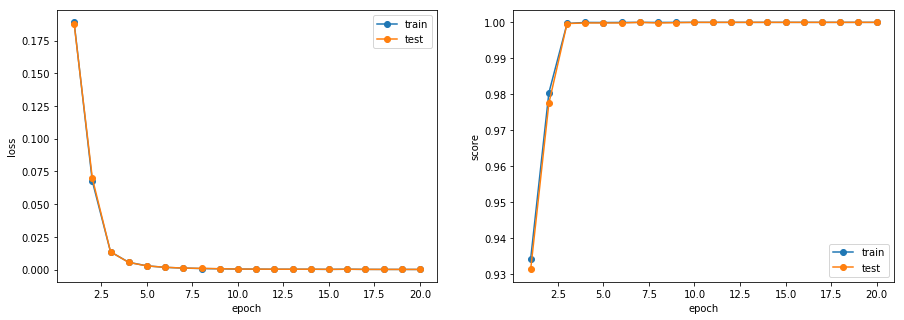

In [6]:
# create folder to save the best network during training
if not os.path.exists('./convNet'):
    os.mkdir('./convNet')
save_path = "./convNet/net.pyt"
# perform training
loss_train, loss_test, score_train, score_test = train(save_path, net, train_data, train_labels, val_data, val_labels, 20)
print("Training complete\n")
# plot error and score
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(np.arange(len(loss_train)) + 1, loss_train, '-o', label='train')
axs[0].plot(np.arange(len(loss_train)) + 1, loss_test, '-o', label='test')
axs[1].plot(np.arange(len(score_train)) + 1, score_train, '-o', label='train')
axs[1].plot(np.arange(len(score_train)) + 1, score_test, '-o', label='test')
#axs[1].set_ylim(0,1)
axs[0].set_xlabel('epoch')
axs[1].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[1].set_ylabel('score')
axs[0].legend()
axs[1].legend()
plt.show()